


![Descripción de la imagen](https://drive.google.com/uc?export=download&id=1LNMJ1zjBZkWJeZwJO38EJzfOWBHt4u4q)


## **Clase 4 - GraphRAG**



In [ ]:
# Install required dependencies
%pip install networkx matplotlib


In [ ]:
# Import required libraries
import asyncio
import networkx as nx
import matplotlib.pyplot as plt


# Objetivos de hoy

**Objetivo Alumno:** Entender las limitaciones del RAG basado en texto y aprender a construir una base de conocimiento en forma de grafo para permitir un razonamiento complejo.

**Objetivo Proyecto:** Crear un Knowledge Graph inicial que modele las relaciones entre productos, proveedores y pedidos.





#Material de Clase
Repositorio de Github

https://github.com/tribu-ia/don-confiado


**Este mismo colab**

[https://colab.research.google.com/drive/1c5H7VbJq47fAt_diSrkIFCP9bpTgtq8](https://colab.research.google.com/drive/1c5H7VbJq47fAt_diSrkIFCP9bpTgtq8)


URL Corta del Colab: [https://tinyurl.com/waftn9z9](https://tinyurl.com/waftn9z9)


**Colab Clase Anterior**:
https://colab.research.google.com/drive/1T15cJEjegMskuDccZoYTDbYWMiO2x1dA





## **Cómo se correlacionan RAG y LLM?**


En la clase pasada vimos como utilizar RAG para traer pedazos de texto (o alguna otra fuente de "conocimiento") desde una base de datos vectorial.


¿Cómo hacemos que ese texto o conocimiento sea usado por LLM para dar una respuesta?


Recuerdan que habíamos explicado que los LLM entre sus características tenían la capacidad de **parafrasear** y **"razonar"**.

Utilizaremos esa caracteristica para enriquecer el **Prompt** inyectando ese texto de RAG en cada llamado.

![Imagen desde Drive](https://drive.google.com/uc?export=view&id=133_lipxQacOQrtF66KP0xL3wOJ2IqQJG)






![Imagen desde Drive](https://drive.google.com/uc?export=view&id=1WK6RyMsWO6EPIwWt7QQw_-BwKxCxFfKP)





# Agenda
* Setup y llaves
* Por qué JSON estructurado para acciones
* Esquemas (Pydantic + JSON Schema)
* Imagen → JSON (demo + ejercicio)
* Audio → Intención (demo + ejercicio)






# *NO MAS TEORIA. VAMOS AL CODIGO*

In [1]:
print("Instalando dotenv")
!pip install --quiet python-dotenv

print("Instalando openai")
!pip install --quiet openai

#print("Instalando genai")
#!pip install --quiet google-genai

!pip install --quiet langchain langchain_google_genai langchain_openai langchain-neo4j langchain-experimental neo4j
print("INSTALO DE TODO. Langchain neo4j Gemini")

Instalando dotenv
Instalando openai
INSTALO DE TODO. Langchain neo4j Gemini


## Cargamos las llaves 🔑


Ahora vamos a poner las llaves o (API_KEYS) de cada plataforma


Recuerden crear los API KEYS de Google Gemini y OpenAI

Google Gemini:  https://aistudio.google.com/api-keys

OpenAI: https://platform.openai.com/api-keys



In [3]:
import os


try:
    from google.colab import userdata
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# =============================================================================
# FROM GOOGLE COLAB
# =============================================================================
try:
    from google.colab import userdata
    # Google Colab - load from userdata
    for key in ["GEMINI_API_KEY", "OPENAI_API_KEY"]:
        try:
            value = userdata.get(key)
            if value:
                os.environ[key] = value
                print(f"✅ {key} cargada desde Google Colab")
        except:
            pass
except ImportError:
    # =============================================================================
    # FROM LOCAL JUPYTER
    # =============================================================================
    try:
        from dotenv import load_dotenv
        load_dotenv()
        print("✅ Variables cargadas desde .env")
    except ImportError:
        print("⚠️ Instalar: pip install python-dotenv")

# Get API keys (with fallback to user input)
for key, prompt in [("GEMINI_API_KEY", "API KEY de Gemini"), ("OPENAI_API_KEY", "API KEY de OpenAI")]:
    if not os.getenv(key):
        os.environ[key] = input(f"Ingrese su {prompt}: ")

gemini_api_key = os.getenv("GEMINI_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")

print("✅ Llaves cargadas correctamente")
print("Puedes pasar a probar los APIs")

✅ Variables cargadas desde .env
✅ Llaves cargadas correctamente
Puedes pasar a probar los APIs


#Definimos algunas funciones útiles para procesar archivos


Como necesitamos processar imagenes y audio vamos a crear unas funciones que nos ayudarán a descargarlas desde Internet y extraer sus bytes

In [ ]:
import requests
import os


# Crearemos algunas funciones útiles para manipular las imágenes.


# Necesitamos cargar los bytes de una imágen en un archivo.
def load_image_bytes(path: str) -> bytes:
    with open(path, "rb") as f:
        return f.read()


#Descargamos la imagen y la guardamos localmente
def descargar_archivo(url: str, destino: str):
    """
    Descarga una imagen desde una URL (por ejemplo, de Google Drive o Imgur)
    y la guarda en la ruta especificada.

    Parámetros:
        url (str): URL directa o de descarga del archivo.
        destino (str): Ruta completa donde guardar la imagen, incluyendo el nombre del archivo.
    """
    print(f"📥 Descargando imagen desde: {url}")

    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(destino, "wb") as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)
        print(f"✅ Imagen descargada correctamente en: {destino}")
    else:
        raise Exception(f"❌ Error al descargar la imagen: {response.status_code}")

    # Verificar que el archivo existe y tiene contenido
    if not os.path.exists(destino) or os.path.getsize(destino) == 0:
        raise FileNotFoundError("❌ No se encontró la imagen descargada o está vacía.")
    else:
        print(f"📏 Tamaño de imagen: {os.path.getsize(destino)} bytes")

# Ejemplo de uso:
# descargar_imagen("https://drive.google.com/uc?export=download&id=1PMXWYR_hekobCV0jSrFEz5TpIjriU6jM", "/content/imagen_imgur.png")




## Introducimos Langchain - Multimodal

![image.png](https://drive.google.com/uc?export=download&id=1UbD5tXczZlVJ3xWH6L4eDk4fn-XkfI3V)



Se puede hacer lo mismo con LANGCHAIN. Y a partir de ahora usaremos solo langchain por estandarización.



In [4]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage , AIMessage


openai_model = init_chat_model("gpt-4.1-mini",      model_provider="openai",        api_key=openai_api_key)
print("OPENAI_MODEL IS ",type(openai_model))

gemini_model = init_chat_model("gemini-2.0-flash", model_provider="google_genai",  api_key=gemini_api_key)
print("GEMINI_MODEL IS ",type(gemini_model))



OPENAI_MODEL IS  <class 'langchain_openai.chat_models.base.ChatOpenAI'>
GEMINI_MODEL IS  <class 'langchain_google_genai.chat_models.ChatGoogleGenerativeAI'>


E0000 00:00:1760882228.140927 7142250 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


## Vamos a crear un Grafo de Don Quijote




In [13]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

print("Cargando Archivo en variable text")
with open("content/don-quijote-short.txt", "r", encoding="utf-8") as f:
    text = f.read()

llm_instruction = """
en el siguiente texto, centrate en buscar relaciones y entidades, como lugares,
eventos significativos en los que participan los personajes, tipo de relacion
entre los personajes, familiaridad entre, propiedades que tienen, gustos y personalizades,
frases o poemas

"""


llm_transformer = LLMGraphTransformer(
    llm=gemini_model,
    additional_instructions=(llm_instruction)
    # allowed_nodes=["Persona","Lugar","Evento"],
    # allowed_relationships=["CONOCIDO", "FAMILIAR", "AMIGO","ESTUVO_EN", 'OCURRIO_EN'],
)
documents = [Document(page_content=text)]

print("Empieza a analizar el documento")
graph_documents = await llm_transformer.aconvert_to_graph_documents(documents)
print("Nodes")
for node in graph_documents[0].nodes:
    print(node)


print("Relationships")
for relationship in graph_documents[0].relationships:
  print(relationship)


Cargando Archivo en variable text
Empieza a analizar el documento
Nodes
id='Don Quijote De La Mancha' type='Person' properties={}
id='Miguel De Cervantes Saavedra' type='Person' properties={}
id='Duque De Béjar' type='Person' properties={}
id='Sancho Panza' type='Person' properties={}
id='Dulcinea Del Toboso' type='Person' properties={}
id='Sansón Carrasco' type='Person' properties={}
id='Teresa Panza' type='Person' properties={}
id='Caballero Del Verde Gabán' type='Person' properties={}
id='Camacho' type='Person' properties={}
id='Basilio' type='Person' properties={}
id='Sierra Morena' type='Place' properties={}
id='La Mancha' type='Place' properties={}
id='El Toboso' type='Place' properties={}
id='Cueva De Montesinos' type='Place' properties={}
id='Benengeli' type='Person' properties={}
id='Rey' type='Person' properties={}
id='Cura' type='Person' properties={}
id='Barbero' type='Person' properties={}
id='Vizcaíno' type='Person' properties={}
id='Marcela' type='Person' properties={}
i

# Una gráfica muy bonita del Grafo

¡Qué bonito! Podemos dibujar las relaciones.


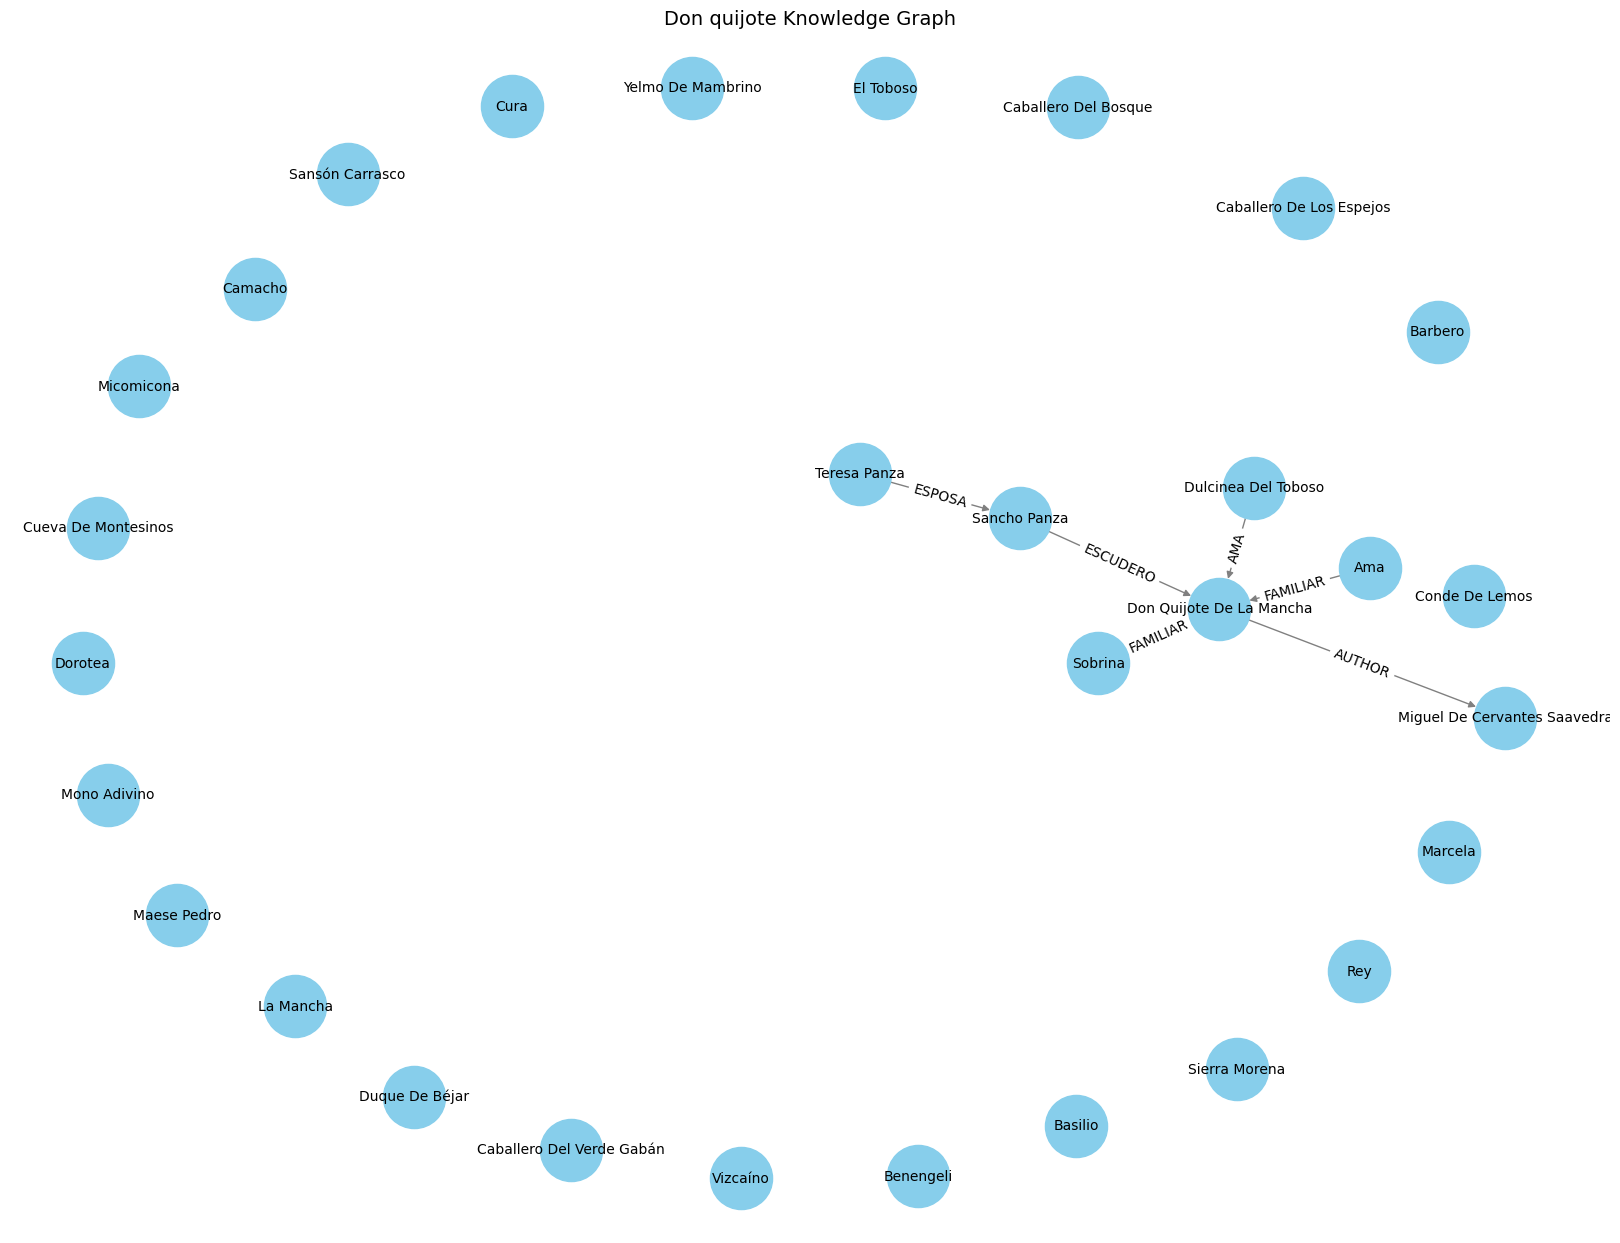

In [14]:
import asyncio
import networkx as nx
import matplotlib.pyplot as plt

graph = graph_documents[0]

# Build a NetworkX graph
G = nx.DiGraph()
for node in graph.nodes:
    G.add_node(node.id, label=node.type)
for rel in graph.relationships:
    G.add_edge(rel.source.id, rel.target.id, label=rel.type)

# Draw it
pos = nx.spring_layout(G, seed=42, k=1.5, iterations=200)
plt.figure(figsize=(16, 12))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', font_size=10)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Don quijote Knowledge Graph", fontsize=14)
plt.show()

## Neo4j - Esto vale la pena guardarlo

Vamos a conectarnos a Neo4j para guardar este grofo



In [15]:
from langchain_neo4j import Neo4jGraph

os.environ["NEO4J_URI"] = "neo4j+s://6ec3c173.databases.neo4j.io"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "pUF62lvAt8ESNINGSmqpFabukdHLV6emQbrKA_V46HI"


# Eliminar DB antes de enviar mas docs
graph = Neo4jGraph(refresh_schema=False)
graph.add_graph_documents(graph_documents, baseEntityLabel=True)



In [23]:
# 🔧 FIXED VERSION - Install required packages for modern PropertyGraphIndex approach
!pip install -U "llama-index>=0.11.0"
!pip install -U llama-index-core llama-index-llms-openai llama-index-readers-file
!pip install -U llama-index-graph-stores-neo4j llama-index-llms-gemini

I0000 00:00:1760885725.481970 7142250 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


I0000 00:00:1760885727.309613 7142250 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


I0000 00:00:1760885729.333214 7142250 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


In [25]:


# Import the modern PropertyGraphIndex components
from llama_index.core import PropertyGraphIndex
from llama_index.core.indices.property_graph import SimpleLLMPathExtractor
from llama_index.graph_stores.neo4j import Neo4jPropertyGraphStore
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.llms.gemini import Gemini

# 🔑 Create LlamaIndex native Gemini LLM (not LangChain)
# This fixes the ValidationError: SimpleLLMPathExtractor needs a LlamaIndex LLM, not LangChain LLM
llamaindex_gemini_llm = Gemini(
    model="models/gemini-2.0-flash",
    api_key=gemini_api_key,
    temperature=0.1,
)

print("✅ LlamaIndex Gemini LLM created")

# Create a proper LlamaIndex Neo4j graph store
neo4j_graph_store = Neo4jPropertyGraphStore(
    username=os.environ["NEO4J_USERNAME"],
    password=os.environ["NEO4J_PASSWORD"],
    url=os.environ["NEO4J_URI"],
)

print("✅ Neo4j graph store created")

# Create PropertyGraphIndex with the documents
property_graph_index = PropertyGraphIndex.from_documents(
    documents,
    llm=llamaindex_gemini_llm,  # ✅ Use LlamaIndex native LLM (not LangChain)
    property_graph_store=neo4j_graph_store,
    kg_extractors=[
        SimpleLLMPathExtractor(
            llm=llamaindex_gemini_llm,  # ✅ Use LlamaIndex native LLM (not LangChain)
            max_paths_per_chunk=10,
        )
    ],
    show_progress=True,
)

print("✅ PropertyGraphIndex created successfully!")


/var/folders/y7/td2w0p4j4lj0qffk54nsysn80000gn/T/ipykernel_76175/2981800989.py:10: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  llamaindex_gemini_llm = Gemini(
E0000 00:00:1760885756.354973 7142250 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


TypeError: Model.__init__() got an unexpected keyword argument 'thinking'

In [ ]:
# 🔧 FIXED QUERY ENGINE - Create retrievers and query engine using the PropertyGraphIndex

# Get different types of retrievers
vector_retriever = property_graph_index.as_retriever(
    include_text=True,  # Include original text chunks
)

# Create a query engine with the CORRECT LlamaIndex LLM
query_engine = property_graph_index.as_query_engine(
    include_text=True,
    response_mode="tree_summarize",
    llm=llamaindex_gemini_llm,  # ✅ Use LlamaIndex native LLM (not LangChain)
)

print("✅ Query engine created successfully!")
print("Now you can query the knowledge graph using:")
print("response = query_engine.query('¿Quién es Don Quijote?')")

# Example queries you can try:
example_queries = [
    "¿Quién es Don Quijote y cuál es su relación con Sancho Panza?",
    "¿Qué lugares aparecen en la historia?",
    "¿Cuáles son las aventuras principales de Don Quijote?",
    "¿Quién es Dulcinea del Toboso?"
]

print("\n📝 Example queries you can try:")
for i, query in enumerate(example_queries, 1):
    print(f"{i}. {query}")

# Try one example query
try:
    print("\n🔍 Testing with example query...")
    response = query_engine.query("¿Quién es Don Quijote y cuál es su relación con Sancho Panza?")
    print("\n--- Example Query Response ---")
    print(response)
except Exception as e:
    print(f"Query example failed: {e}")
    print("This is normal if the graph is still being built. Try running the query manually.")


In [27]:
from langchain_neo4j import Neo4jGraph
from langchain_neo4j.chains.graph_qa.cypher import GraphCypherQAChain
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage

chain = GraphCypherQAChain.from_llm(
    gemini_model,
    graph=graph,
    # cypher_prompt=ChatPromptTemplate.from_template(schema_prompt), # Pass the schema_prompt as a ChatPromptTemplate
    validate_cypher=True,                 # uses built-in schema helpers
    return_intermediate_steps=True,
    allow_dangerous_requests=True

)

resp = chain.invoke({"query": "who likes whom"})
print(resp["result"])

Don Quijote likes Feliciano De Silva, Bernardo Del Carpio, Morgante, and Reinaldos De Montalbán.


# Ahora Con Neo4j Libary


In [28]:
!pip install --quiet neo4j
!pip install --quiet neo4j-graphrag

I0000 00:00:1760886026.970750 7142250 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1760886028.363660 7142250 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


In [ ]:

# Node labels
basic_node_labels = ["Object", "Entity", "Group", "Person", "Organization", "Place"]

literary_node_labels = [
    "Character",          # named person in the story (can also use Person)
    "Creature",           # animal or mythical being (e.g., Rocinante)
    "Artifact",           # weapons, armor, books, tools
    "Vehicle",            # carts, ships, mounts (can overlap with Creature if mount)
    "RoleOrTitle",        # Knight, Squire, Innkeeper, Duke
    "Event",              # discrete happenings (battles, ceremonies)
    "Scene",              # localized scene
    "Chapter",            # chapter-level container
    "JourneyOrQuest",     # long-running endeavor
    "Theme",              # chivalry, honor, madness, satire
    "Motif",              # windmills, disguises, letters
    "QuoteOrUtterance",   # notable spoken lines
    "WorkOfFiction",      # the book or embedded works
    "TimePeriod"          # day, night, specific historical period
]



node_labels = basic_node_labels + literary_node_labels

# Relationship types (directed)
rel_types = [
    "INTERACTS_WITH",      # Character -> Character
    "COMPANION_OF",        # Character/Person -> Character/Person
    "FRIEND_OF",           # Character/Person -> Character/Person
    "ENEMY_OF",            # Character/Person -> Character/Person
    "SERVES",              # Squire/Servant -> Knight/Master
    "MENTORS",             # Person -> Person
    "LOVES",               # Person -> Person
    "DECEIVES",            # Person -> Person
    "INSULTS",             # Person -> Person
    "PRAISES",             # Person -> Person
    "ATTACKS",             # Person -> Person
    "DEFENDS",             # Person -> Person

    "RIDES",               # Person -> Creature/Vehicle
    "CARRIES",             # Person -> Artifact/Object
    "WIELDS",              # Person -> Artifact
    "OWNS",                # Person/Organization -> Object/Artifact/Creature
    "HAS_ROLE",            # Person/Character -> RoleOrTitle
    "MEMBER_OF",           # Person -> Group/Organization

    "TRAVELS_TO",          # Person/Group -> Place
    "LOCATED_IN",          # Entity -> Place
    "SET_IN",              # WorkOfFiction/Scene/Chapter -> Place/TimePeriod
    "APPEARS_IN",          # Entity -> Scene/Chapter/Event/WorkOfFiction
    "OCCURS_IN",           # Event -> Place/TimePeriod
    "HAPPENS_AFTER",       # Event -> Event
    "CAUSES",              # Event/Entity -> Event/Outcome (describe in properties.details)

    "DESCRIBES",           # QuoteOrUtterance/Person -> Entity/Theme/Motif (use properties.details)
    "MENTIONS",            # QuoteOrUtterance/Entity -> Entity
    "ASSOCIATED_WITH",     # Entity -> Theme/Motif
    "ALIAS_OF",            # Character/Person -> Character/Person

    "SEEKS",               # Person -> Object/Goal/JourneyOrQuest
    "QUEST_PART_OF",       # Event/Scene -> JourneyOrQuest
    "CONFERS_TITLE_ON",    # Person -> Person (e.g., knighting)
    "INCLUDES",            # WorkOfFiction/Chapter/Scene -> Entity
    "AUTHORED",            # Person -> WorkOfFiction
    "PUBLISHED_IN"         # WorkOfFiction -> PublicationOrEdition
]

examples = """
Example 1
Input:
Don Quijote and Sancho Panza travel to an inn near Puerto Lápice. Don Quijote calls the inn a castle.
He rides Rocinante and carries a lance and a shield. The innkeeper knights him as a 'Knight'.

Output:
{"nodes": [
  {"id": "0", "label": "Person", "properties": {"name": "Don Quijote"}},
  {"id": "1", "label": "Person", "properties": {"name": "Sancho Panza"}},
  {"id": "2", "label": "Place", "properties": {"name": "Puerto Lápice"}},
  {"id": "3", "label": "Place", "properties": {"name": "inn near Puerto Lápice"}},
  {"id": "4", "label": "Creature", "properties": {"name": "Rocinante"}},
  {"id": "5", "label": "Artifact", "properties": {"name": "lance"}},
  {"id": "6", "label": "Artifact", "properties": {"name": "shield"}},
  {"id": "7", "label": "Person", "properties": {"name": "innkeeper"}},
  {"id": "8", "label": "RoleOrTitle", "properties": {"name": "Knight"}}
],
"relationships": [
  {"type": "COMPANION_OF", "start_node_id": "0", "end_node_id": "1", "properties": {"details": "travel together"}},
  {"type": "TRAVELS_TO", "start_node_id": "0", "end_node_id": "3", "properties": {"details": "journey"}},
  {"type": "LOCATED_IN", "start_node_id": "3", "end_node_id": "2", "properties": {"details": "inn is near Puerto Lápice"}},
  {"type": "DESCRIBES", "start_node_id": "0", "end_node_id": "3", "properties": {"details": "calls the inn a castle"}},
  {"type": "RIDES", "start_node_id": "0", "end_node_id": "4", "properties": {"details": "mount"}},
  {"type": "CARRIES", "start_node_id": "0", "end_node_id": "5", "properties": {"details": "weapon"}},
  {"type": "CARRIES", "start_node_id": "0", "end_node_id": "6", "properties": {"details": "protection"}},
  {"type": "CONFERS_TITLE_ON", "start_node_id": "7", "end_node_id": "0", "properties": {"details": "knighting ceremony"}},
  {"type": "HAS_ROLE", "start_node_id": "0", "end_node_id": "8", "properties": {"details": "after ceremony"}}
]}
"""

schema = f"""
Allowed node labels: {sorted(set(node_labels))}
Allowed relationship types: {sorted(set(rel_types))}
"""


graph_prompt_template = '''
You are a literary researcher tasked with extracting information from narrative prose (e.g., novels)
and structuring it in a property graph to inform further literary analysis and Q&A.

Extract the entities (nodes) and specify their type from the following Input text.
Also extract the relationships between these nodes. The relationship direction goes from the start node to the end node.

Return result as JSON using the following format:
{"nodes": [ {"id": "0", "label": "the type of entity", "properties": {"name": "name of entity"}} ],
 "relationships": [{"type": "TYPE_OF_RELATIONSHIP", "start_node_id": "0", "end_node_id": "1", "properties": {"details": "Description of the relationship"}} ]}

- Use only the information from the Input text. Do not add any additional information.
- If the input text is empty, return {"nodes": [], "relationships": []}.
- Create as many nodes and relationships as needed to capture rich narrative context: characters, roles, groups, places, events, objects, quotes, themes, and time.
- An AI knowledge assistant must be able to read this graph and immediately understand the context to inform detailed literary questions.
- Multiple documents will be ingested from different sources; keep entity types fairly general to enable linking across texts.
- Always include properties.name for nodes; add additional properties only if explicitly present in the text (e.g., aliases, epithet, role, quote_text, time_period, chapter, location_detail).

Use only the following nodes and relationships (if provided):
{schema}

Assign a unique ID (string) to each node, and reuse it to define relationships.
Do respect the source and target node types for relationships and the relationship direction.

Do not return any additional information other than the JSON.

Examples:
{examples}


'''

In [ ]:
import neo4j
from neo4j_graphrag.llm import OpenAILLM as LLM
from neo4j_graphrag.embeddings.openai import OpenAIEmbeddings as Embeddings
from neo4j_graphrag.experimental.pipeline.kg_builder import SimpleKGPipeline
from neo4j_graphrag.retrievers import VectorRetriever
from neo4j_graphrag.generation.graphrag import GraphRAG
from neo4j_graphrag.experimental.components.text_splitters.fixed_size_splitter import FixedSizeSplitter


neo4j_driver = neo4j.GraphDatabase.driver(os.environ["NEO4J_URI"],
                                          auth=(os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"]))

ex_llm=LLM(
   model_name="gpt-4o-mini",
   model_params={
       "response_format": {"type": "json_object"},
       "temperature": 0
   })

embedder = Embeddings()

llm_graph_instruction = """
en el siguiente texto, centrate en buscar relaciones y entidades, como lugares,
eventos significativos en los que participan los personajes, tipo de relacion
entre los personajes, familiaridad entre, propiedades que tienen, gustos y personalizades,
frases o poemas

"""

# 1. Build KG and Store in Neo4j Database
kg_builder_pdf = SimpleKGPipeline(
   llm=ex_llm,
   driver=neo4j_driver,
   text_splitter=FixedSizeSplitter(chunk_size=500, chunk_overlap=100),
   embedder=embedder,
   # entities=node_labels,
   # relations=rel_types,
   prompt_template=llm_instruction,
   from_pdf=True
)
await kg_builder_pdf.run_async(file_path='content/don-quijote-short.pdf')


LLMGenerationError: Error code: 400 - {'error': {'message': "'messages' must contain the word 'json' in some form, to use 'response_format' of type 'json_object'.", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}

In [43]:
from neo4j_graphrag.indexes import create_vector_index

create_vector_index(neo4j_driver, name="text_embeddings", label="Chunk",
                    embedding_property="embedding", dimensions=1536, similarity_fn="cosine")

In [41]:


# 2. KG Retriever
vector_retriever = VectorRetriever(
   neo4j_driver,
   index_name="text_embeddings",
   embedder=embedder
)

# 3. GraphRAG Class
llm = LLM(model_name="gpt-4o")
rag = GraphRAG(llm=llm, retriever=vector_retriever)

# 4. Run
response = rag.search( "Con quien esta relacionado quien mato a roldan")
print(response.answer)

#output


La persona relacionada con quien mató a Roldán es Bernardo del Carpio, según las leyendas y los cantares de gesta medievales.
